In [3]:
import pystan
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline

#In multiple places there is reformatted code taken from session 14.1

In [4]:
#first, clean the data
#datetime suggested by maike 
co2_data = pd.read_csv('mauna_loa.csv', names=['Date', 'Co2'],
                 skiprows=44,header=None)

from datetime import datetime
from datetime import timedelta

def days_past(start, current):
    start = datetime.strptime(start, "%Y-%m-%d")
    current = datetime.strptime(current, "%Y-%m-%d")
    return int((current-start).days)

#creating a time array to store time values 
time = []
#first populate with existing date data
for i in range(0,len(co2_data.Date)):
    first = co2_data.Date[0]
    time.append(days_past(first, co2_data.Date[i]))

#Then need to add additional time points for the data we will collect
#Because(40*52 = 2080) I need to append an additional 2080 data points
last_day = time[3138]
for i in range(1,2081):
    time.append(last_day + 7*(i))

In [5]:
#created variable all_dates for use in later model visualizations for date of measurement 
dates = list(pd.to_datetime(co2_data['Date']))
future_dates = [dates[-1] + timedelta(days=7)]

for i in range(1, 2080):
    future_dates.append(future_dates[i-1] + timedelta(days=7))    
all_dates = dates+future_dates

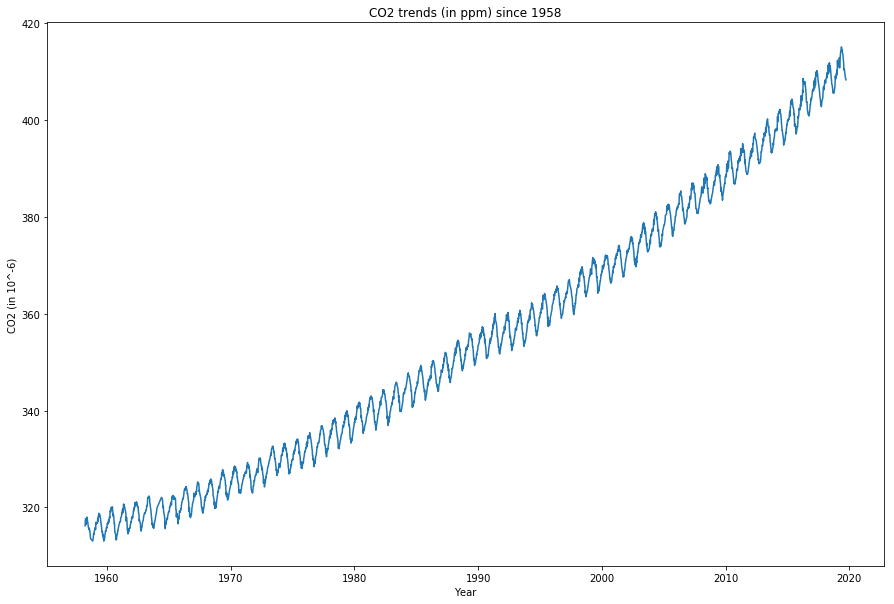

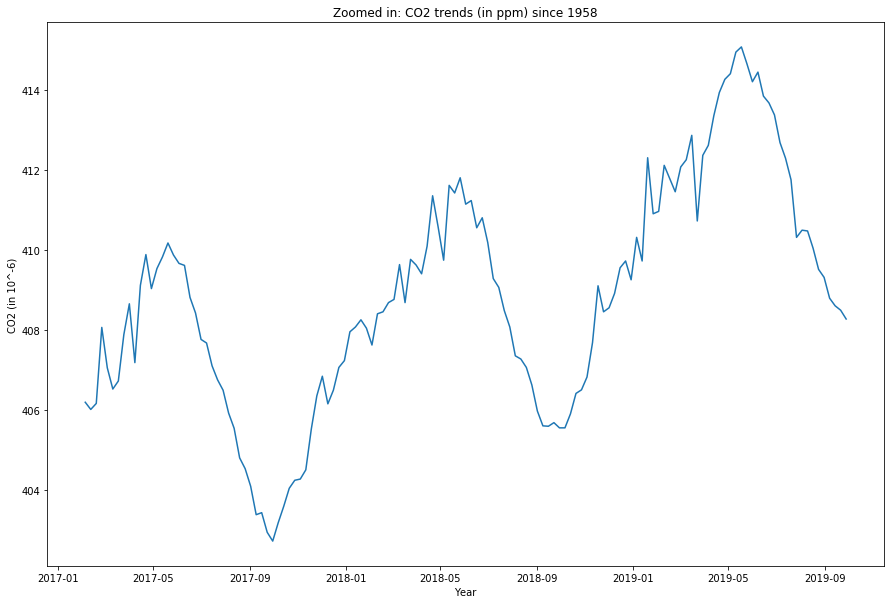

In [6]:
#original mauna loa data
plt.figure(figsize=(15,10))
plt.plot(all_dates[0:3139], co2_data['Co2'])
plt.ylabel('CO2 (in 10^-6)')
plt.xlabel('Year')
plt.title('CO2 trends (in ppm) since 1958')
plt.show()

#zoomed in
plt.figure(figsize=(15,10))
plt.plot(all_dates[3000:3139], co2_data['Co2'][3000:3139])
plt.ylabel('CO2 (in 10^-6)')
plt.xlabel('Year')
plt.title('Zoomed in: CO2 trends (in ppm) since 1958')
plt.show()


In [7]:
linear_model = """
data {
    int<lower=0> n;  // number of data points
    real<lower=0> co2[n];  // co2 data 
    real t[n]; // data for given day
}

parameters {
    real<lower=0> c_0; // y-intercept
    real<lower=0> c_1; // 1st degree polynomial 
    real<lower=0> c_2; // noise
    real<lower=0> c_3; //phi, phase shift
    real<lower=0> c_4; //amplitdue
}


model {
    // priors 
    c_0 ~ normal(300, 20);
    c_1 ~ normal(0,20);  //broad prior
    c_2 ~ normal(0,20);  //broad prior
    c_3 ~ normal(0,20);  //broad prior
    c_4 ~ normal(0,20);  //broad prior
    
    // model
    for (i in 1:n) {   
        co2[i] ~ normal(c_0 + c_1*t[i] +c_4*cos(((2*pi()*t[i])/365.25)+c_3),c_2);
        //original linear function which incorporates seasonal variation
        }    
}

"""
stan_model = pystan.StanModel(model_code=linear_model)
print('Model Compiled')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8eb121a350a075abc0a82d87ed54587e NOW.


Model Compiled


In [8]:
linear_data = { 
    'n':3139, 
    'co2': co2_data['Co2'], 
    't': time[0:3139]
}

lin_parameters = ['c_0', 'c_1', 'c_2','c_3','c_4']

linear_results = stan_model.sampling(data=linear_data)
print(linear_results.stansummary(pars=lin_parameters))
lin = linear_results.extract()

Inference for Stan model: anon_model_8eb121a350a075abc0a82d87ed54587e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c_0 306.09  2.3e-3   0.13 305.81  306.0 306.09 306.18 306.35   3580    1.0
c_1 4.3e-3  1.7e-7 1.0e-5 4.3e-3 4.3e-3 4.3e-3 4.3e-3 4.3e-3   3649    1.0
c_2   3.82    0.03   0.07   3.69   3.78   3.83   3.87   3.94      4   1.38
c_3   1.46    1.79   2.53 1.4e-4 1.3e-3 3.3e-3   3.17   5.89      2 159.95
c_4   2.69    0.09   0.15   2.44   2.58   2.66   2.79   3.01      3   1.65

Samples were drawn using NUTS at Fri Dec 20 14:48:35 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


Text(0.5, 1.0, 'Original Data vs. Linear Model Predictions')

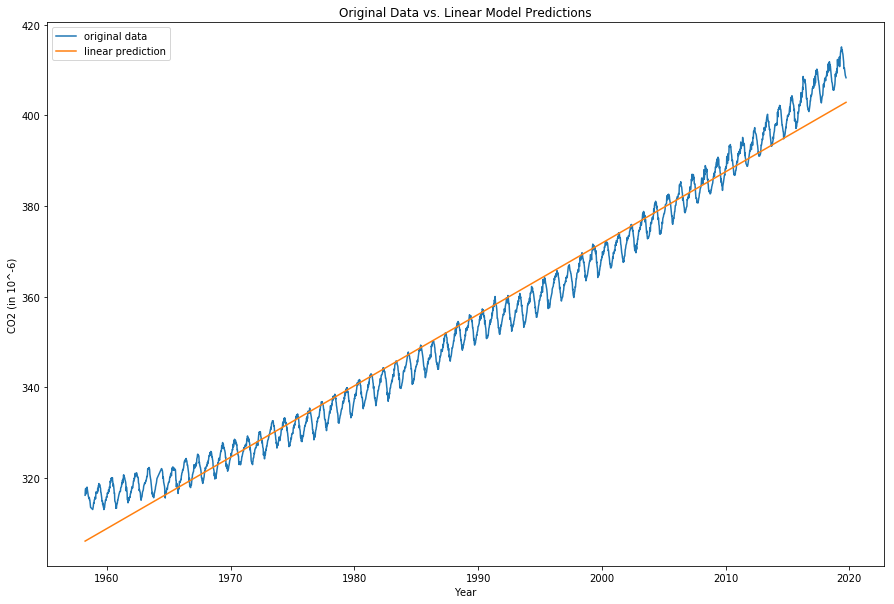

In [9]:
#visualizing the original, linear model 
l_c0 = lin['c_0']
l_c1 = lin['c_1']
lin_means = []
for i in range(len(co2_data)):
    lin_means.append(l_c0.mean() + l_c1.mean()*time[i])

plt.figure(figsize=(15,10))
plt.plot(all_dates[0:3139], co2_data['Co2'][0:3139].values, label = 'original data')
plt.plot(all_dates[0:3139],lin_means, label='linear prediction')
plt.xlabel('Year')
plt.ylabel('CO2 (in 10^-6)')
plt.legend()
plt.title('Original Data vs. Linear Model Predictions')

In [11]:
#stan model code for improved, quadratic model 
stan_code = """
data {
    int<lower=0> n;        // The number of data
    real co2[n];           // co2 data
    int<lower=0> n_pred; 
    real t[n_pred];        // days since first measurement
}

parameters {
    real<lower=0> c_0;  // quad parameter
    real<lower=0> c_1;  // quad parameter
    real<lower=0> c_2;  // quad parameter
    real c3_x;          // seasonal parameter, phi
    real c3_y;          // seasonal parameter, phi
    real<lower=0> c_4;  // seasonal parameter, amplitude
    real<lower=0> c_5;  // noise parameter
}

transformed parameters {
    real<lower=0> c_3;
    c_3 = atan2(c3_x, c3_y); //phi
} 


model {
    c_0 ~ normal(0,20);   //broad distribution
    c_1 ~ normal(0,20);   //broad distribution
    c_2 ~ normal(300,20); //broad distribution centered around initial data point
    c3_x ~ normal(0,1);   //phase variable, broad distribution
    c3_y ~ normal(0,1);   //phase variable, broad distribution
    c_4 ~ normal(0,20);   //broad distribution
    c_5 ~ normal(0,20);   //broad distribution
    
    for(i in 1:n) {
        co2[i] ~ normal(c_0*(t[i])^2 + c_1*(t[i])+c_2+c_4*sin(((2*pi()*t[i])/365.25)+c_3),c_5);
        //quadratic likelihood which incorporates seasonal variation, change from cos to sin
    }
    
}

generated quantities {
    real CO2_future[n_pred];
    for(i in 1:n_pred) {
        CO2_future[i] = normal_rng(c_0*(t[i])^2 + c_1*(t[i])+c_2+c_4*sin(((2*pi()*t[i])/365.25)+c_3),c_5);
        }
}
"""
stan_model = pystan.StanModel(model_code=stan_code)
print('Model Compiled')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e84da2d880f0ddae1d1728dc71d37010 NOW.


Model Compiled


In [13]:
stan_data = { 
    'n': 3139, 
    'n_pred':5219,          #5219 because we want to predict all the data
    'co2': co2_data['Co2'], 
    't': time
}

In [14]:
parameters = ['c_0','c_1','c_2','c_3','c_4','c_5']

results = stan_model.sampling(data=stan_data)
print(results.stansummary(pars=parameters))
samples = results.extract()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_e84da2d880f0ddae1d1728dc71d37010.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c_0 9.7e-8 1.1e-114.7e-10 9.6e-8 9.7e-8 9.7e-8 9.7e-8 9.8e-8   1875    1.0
c_1 2.1e-3  2.5e-7 1.1e-5 2.1e-3 2.1e-3 2.1e-3 2.1e-3 2.1e-3   1889    1.0
c_2 314.57  1.1e-3   0.05 314.46 314.53 314.57  314.6 314.67   2322    1.0
c_3   1.15  1.4e-4 8.9e-3   1.14   1.15   1.15   1.16   1.17   3912    1.0
c_4   2.86  5.0e-4   0.02   2.81   2.84   2.86   2.88   2.91   2475    1.0
c_5   0.99  2.5e-4   0.01   0.96   0.98   0.99   0.99   1.01   2528    1.0

Samples were drawn using NUTS at Fri Dec 20 15:02:28 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


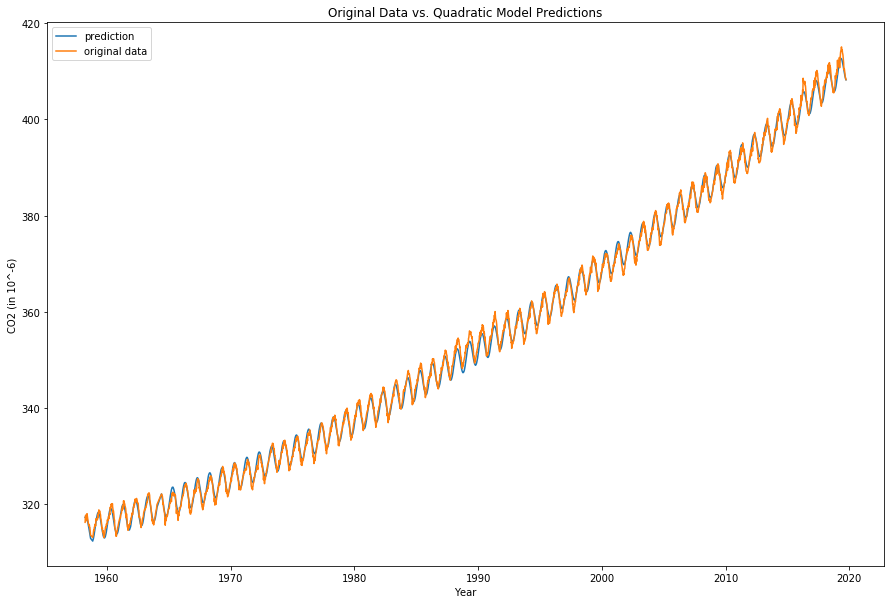

In [15]:
#visualization of improved, quadratic model 
prediction = samples['CO2_future']
mean_pred = [] #array for the mean of each prediction sample

#populate the mean prediction array with means
for i in range(0,5219):
    mean_pred.append(np.mean(prediction[:,i]))

plt.figure(figsize=(15,10))
plt.plot(all_dates[0:3139],mean_pred[0:3139], label='prediction') #predictions
plt.plot(all_dates[0:3139], co2_data['Co2'], label = 'original data')
plt.ylabel('CO2 (in 10^-6)')
plt.xlabel('Year')
plt.title('Original Data vs. Quadratic Model Predictions')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Improved (Quadratic) Time Trend with RMSE of 0.98')

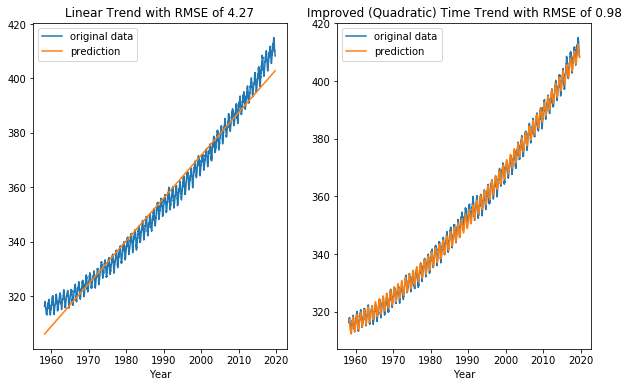

In [24]:
#But how much better is the second model? 
#Test Statistic: Assessing RSME 
#T-Statistic: Assessing RSME 

#linear model 
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(all_dates[0:3139], co2_data['Co2'][0:3139].values, label = 'original data')
plt.plot(all_dates[0:3139],lin_means, label='prediction')
lin_residuals =  co2_data['Co2'][0:3139] - lin_means[0:3139]
plt.xlabel('Year')
plt.legend()
plt.title('Linear Trend with RMSE of {}'.format(round(np.sqrt(np.mean(lin_residuals**2)),2)))

#improved quadratic model 
residuals = co2_data['Co2'][0:3139] - mean_pred[0:3139]
plt.subplot(1, 2, 2)
plt.plot(all_dates[0:3139], co2_data['Co2'][0:3139].values, label = 'original data')
plt.plot(all_dates[0:3139],mean_pred[0:3139], label='prediction')
plt.xlabel('Year')
plt.legend()
plt.title('Improved (Quadratic) Time Trend with RMSE of {}'.format(round(np.sqrt(np.mean(residuals**2)),2)))



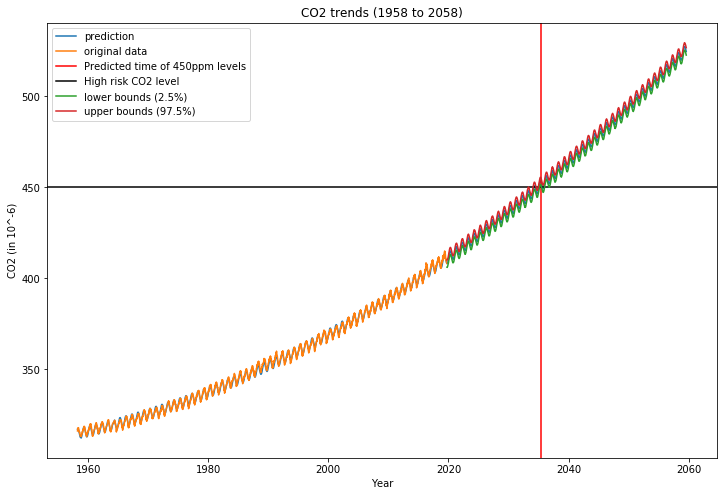

In [17]:
#create a visualization to compare original data, predicted data, high risk cutoff (450)

plt.figure(figsize=(12, 8))
plt.plot(all_dates,mean_pred[0:5219], label='prediction') #predictions
plt.plot(dates, co2_data['Co2'], label = 'original data')
plt.axvline(all_dates[3960], color='red', label = "Predicted time of 450ppm levels")
plt.axhline(450, color='black', label='High risk CO2 level')
plt.plot(future_dates,prediction_interval[0][3139:5219], label='lower bounds (2.5%)') #lower conf.int.
plt.plot(future_dates,prediction_interval[1][3139:5219], label='upper bounds (97.5%)') #upper conf.int.
plt.ylabel('CO2 (in 10^-6)')
plt.xlabel('Year')
plt.title('CO2 trends (1958 to 2058)')
plt.legend()
plt.show()

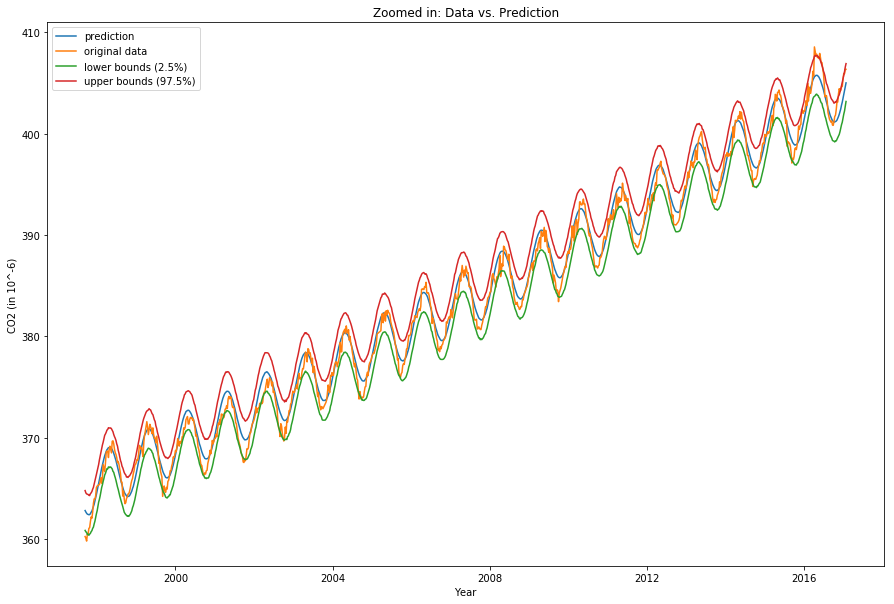

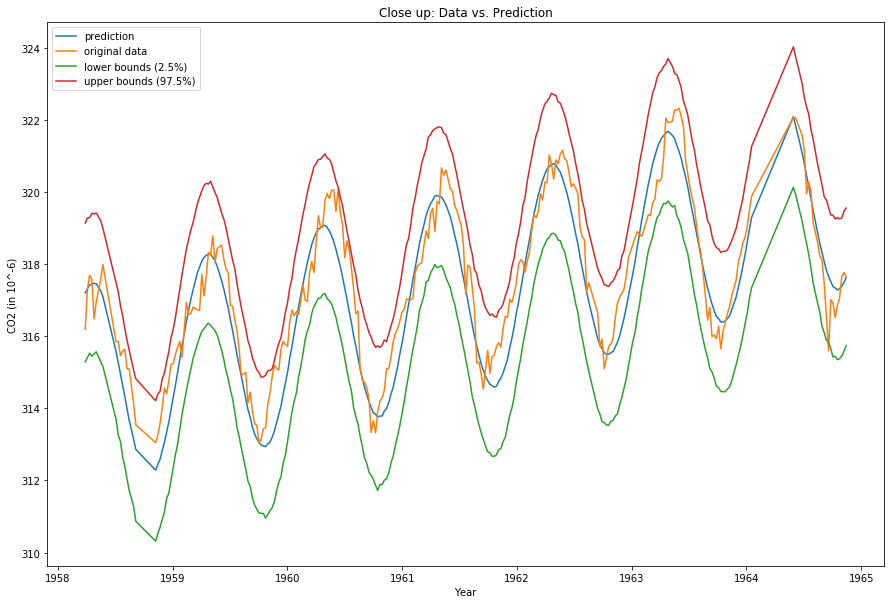

In [18]:
#visualizing the model
prediction = samples['CO2_future']
mean_pred = [] #array for the mean of each prediction sample
prediction_interval = np.percentile(prediction,axis=0,q=[2.5,50,97.5]) # 95% confidence interval
for i in range(0,5219):
    mean_pred.append(np.mean(prediction[:,i]))

plt.figure(figsize=(15, 10))
idx_start = 2000
idx_end = 3000
plt.plot(all_dates[idx_start:idx_end],mean_pred[idx_start:idx_end], label='prediction') #predictions
plt.plot(all_dates[idx_start:idx_end], co2_data['Co2'][idx_start:idx_end], label = 'original data')
plt.plot(all_dates[idx_start:idx_end],prediction_interval[0][idx_start:idx_end], label='lower bounds (2.5%)') #lower conf.int.
plt.plot(all_dates[idx_start:idx_end],prediction_interval[2][idx_start:idx_end], label='upper bounds (97.5%)') #upper conf.int.
plt.ylabel('CO2 (in 10^-6)')
plt.xlabel('Year')
plt.title('Zoomed in: Data vs. Prediction')
plt.legend()
plt.show()

#zooming in 
plt.figure(figsize=(15, 10))
idx_start = 0
idx_end = 300
plt.plot(all_dates[idx_start:idx_end],mean_pred[idx_start:idx_end], label='prediction') #predictions
plt.plot(all_dates[idx_start:idx_end], co2_data['Co2'][idx_start:idx_end], label = 'original data')
plt.plot(all_dates[idx_start:idx_end],prediction_interval[0][idx_start:idx_end], label='lower bounds (2.5%)') #lower conf.int.
plt.plot(all_dates[idx_start:idx_end],prediction_interval[2][idx_start:idx_end], label='upper bounds (97.5%)') #upper conf.int.
plt.ylabel('CO2 (in 10^-6)')
plt.xlabel('Year')
plt.title('Close up: Data vs. Prediction')
plt.legend()
plt.show()

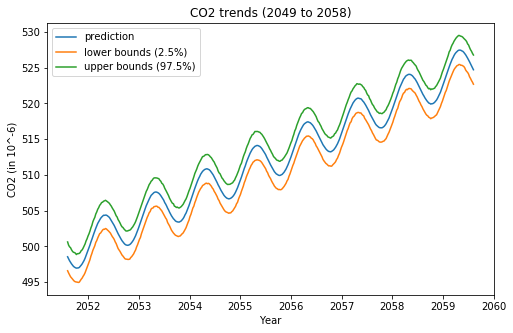

Predicted value 524.7161134054217
Predicted lower bound 522.6937181361517
Predicted upper bound 526.7771846295625


In [19]:
#visualizing the model
prediction = samples['CO2_future']

mean_pred = [] #array for the mean of each prediction sample
prediction_interval = np.percentile(prediction,axis=0,q=[2.5,50,97.5]) # 95% confidence interval

for i in range(0,5219):
    mean_pred.append(np.mean(prediction[:,i]))

plt.figure(figsize=(8,5))
plt.plot(all_dates[4800:5219],mean_pred[4800:5219], label='prediction') #predictions
#plt.plot(time[0:3139], co2_data['Co2'], label = 'original data')
plt.plot(all_dates[4800:5219],prediction_interval[0][4800:5219], label='lower bounds (2.5%)') #lower conf.int.
plt.plot(all_dates[4800:5219],prediction_interval[2][4800:5219], label='upper bounds (97.5%)') #upper conf.int.
plt.ylabel('CO2 (in 10^-6)')
plt.xlabel('Year')
plt.title('CO2 trends (2049 to 2058)')
plt.legend()
plt.show()
print("Predicted value", mean_pred[5218])
print("Predicted lower bound", prediction_interval[0][5218])
print("Predicted upper bound", prediction_interval[2][5218])

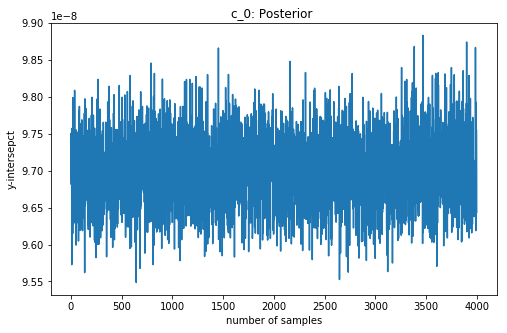

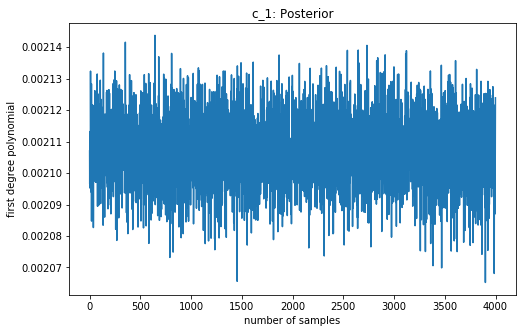

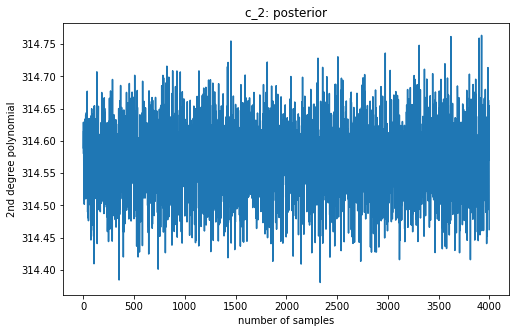

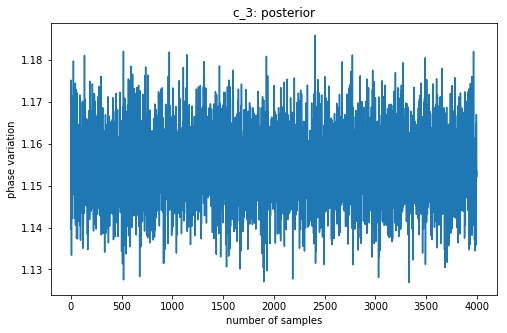

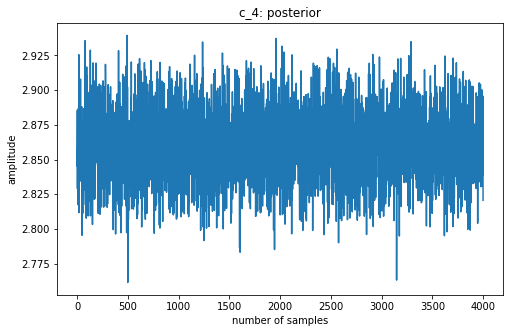

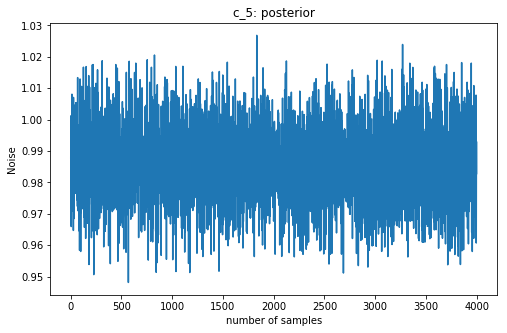

In [20]:
## Plotting posteriors 
#Plotting Posterior Distributions for c_0:
extracted = (results.extract())
extracted['c_0']

plt.figure(figsize=(8,5))
plt.plot(extracted['c_0'])
plt.title('c_0: Posterior ')
plt.ylabel('y-intersepct')
plt.xlabel('number of samples')
plt.show()

#Plotting Posterior Distributions for c_1:
extracted = (results.extract())
extracted['c_1']

plt.figure(figsize=(8,5))
plt.plot(extracted['c_1'])
plt.title('c_1: Posterior')
plt.ylabel('first degree polynomial')
plt.xlabel('number of samples')
plt.show()

#Plotting Posterior Distributions for c_2:
extracted = (results.extract())
extracted['c_2']

plt.figure(figsize=(8,5))
plt.plot(extracted['c_2'])
plt.title('c_2: posterior')
plt.ylabel('2nd degree polynomial')
plt.xlabel('number of samples')
plt.show()

#Plotting Posterior Distributions for c_3:
extracted = (results.extract())
extracted['c_3']

plt.figure(figsize=(8,5))
plt.plot(extracted['c_3'])
plt.title('c_3: posterior')
plt.ylabel('phase variation')
plt.xlabel('number of samples')
plt.show()

#Plotting Posterior Distributions for c_4:
extracted = (results.extract())
extracted['c_4']

plt.figure(figsize=(8,5))
plt.plot(extracted['c_4'])
plt.title('c_4: posterior')
plt.ylabel('amplitude')
plt.xlabel('number of samples')
plt.show()

#Posterior Distributions for c_5:
extracted = (results.extract())
extracted['c_5']

plt.figure(figsize=(8,5))
plt.plot(extracted['c_5'])
plt.title('c_5: posterior')
plt.ylabel('Noise')
plt.xlabel('number of samples')
plt.show()

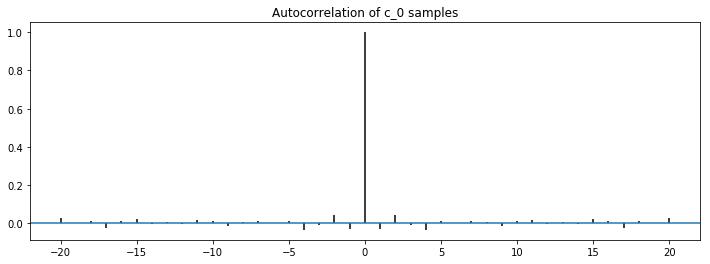

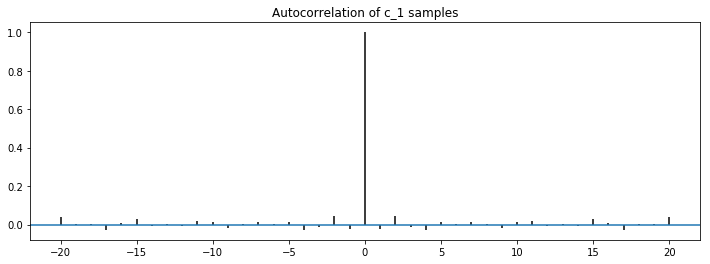

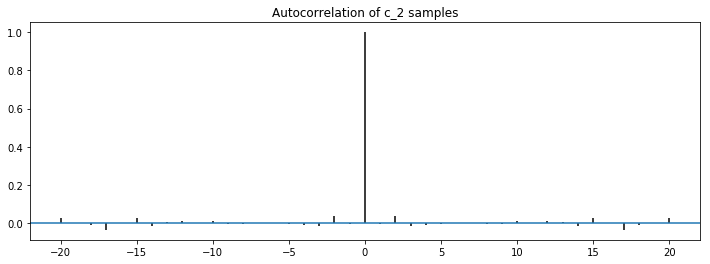

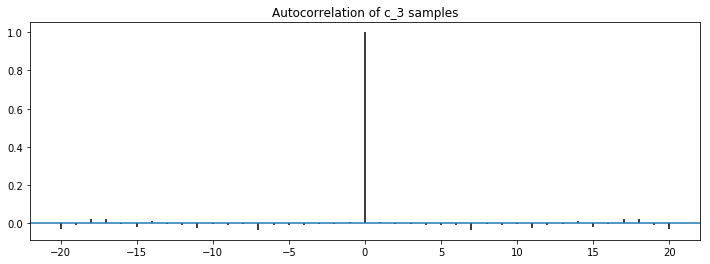

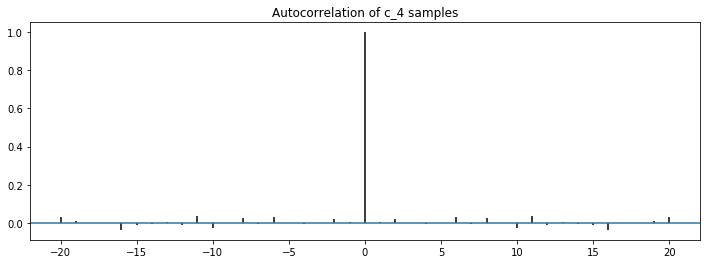

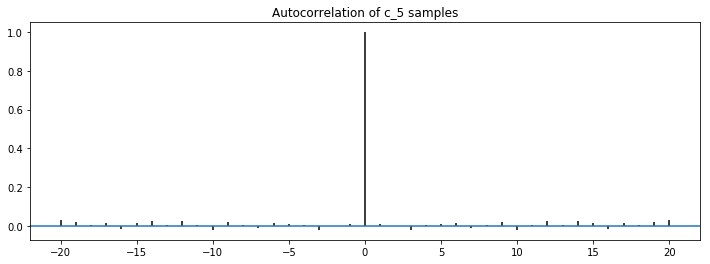

In [22]:
#Autocorrelation Plots: These show the degree of independence between variables 

def plot_acf(x):
    '''
    Plot the autocorrelation function for a series x. This corresponds to the
    acf() function in R. The series x is detrended by subtracting the mean of
    the series before computing the autocorrelation.
    '''
    from scipy import signal
    plt.acorr(
        x, maxlags=20, detrend=lambda x: signal.detrend(x, type='constant'))

for param in parameters:
    plt.figure(figsize=(12, 4))#
    plot_acf(samples[param])
    plt.title(f'Autocorrelation of {param} samples')

plt.show()

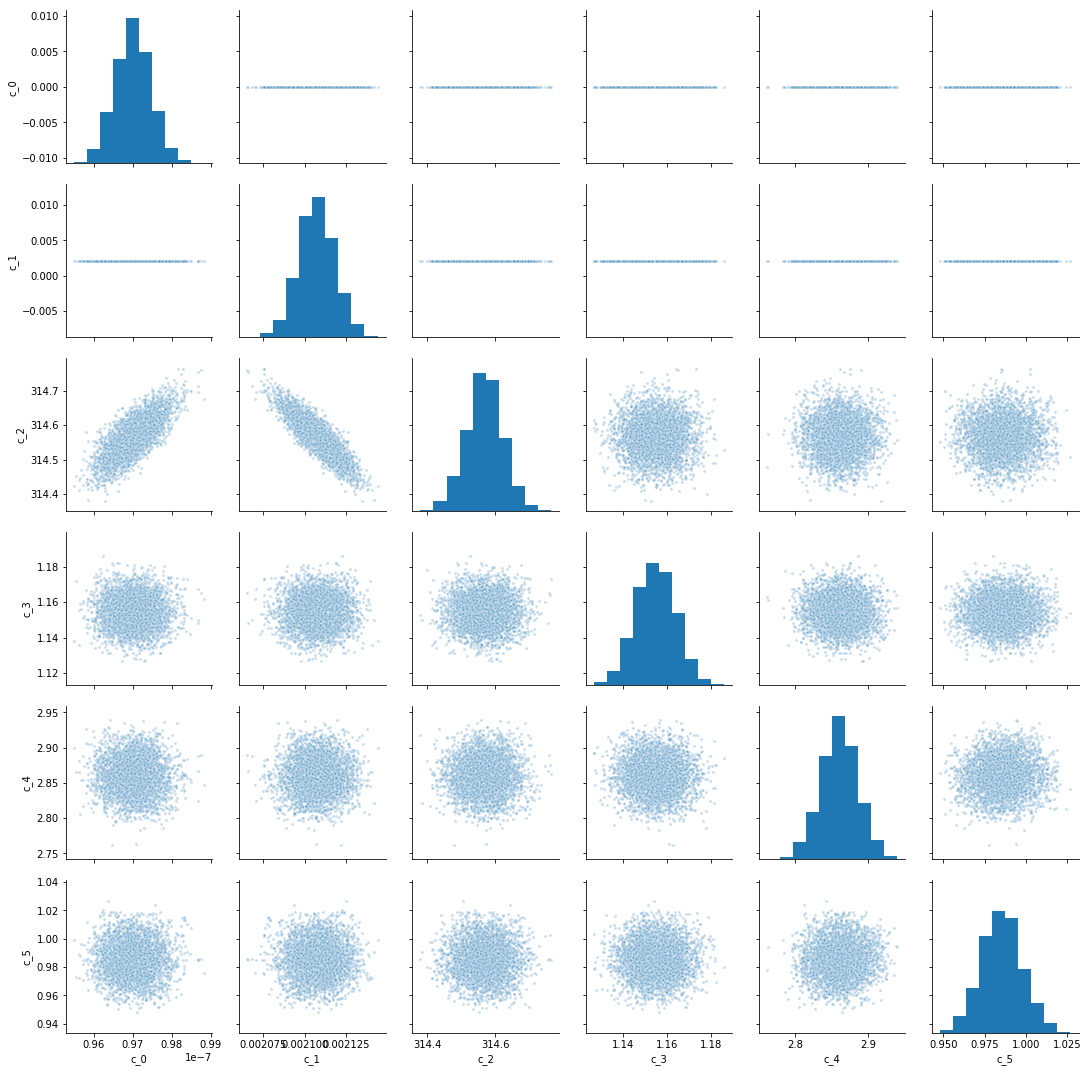

In [21]:
#pair plots 
df = pd.DataFrame(
    data=np.transpose([samples[param] for param in parameters]),
    columns=parameters)
sns.pairplot(df, size=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()